In [1]:
import os
import sys
import numpy as np
import pandas as pd
import sqlalchemy
import logging
import time
from math import log
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')

from itertools import product
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [47]:
def ic_scale(pwm,background):
    odds_ratio = ((pwm+0.001)/(1.004))/(background[None,:])
    ic = ((np.log((pwm+0.001)/(1.004))/np.log(2))*pwm -\
            (np.log(background)*background/np.log(2))[None,:])
    return pwm*(np.sum(ic,axis=1)[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(
            matplotlib.patches.Polygon(
                (np.array([1,height])[None,:]*polygon_coords
                 + np.array([left_edge,base])[None,:]),
                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.825, base+0.085*height],
        width=0.174, height=0.415*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.625, base+0.35*height],
        width=0.374, height=0.15*height,
        facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
        width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
        width=1.0, height=0.2*height, facecolor=color,
        edgecolor=color, fill=True))

    
def plot_u(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.95, height=0.8*height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.025, base+0.4*height], width=0.95, height=0.6*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.6175, height=0.52*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.19125, base+0.4*height], width=0.6175, height=0.6*height,
        facecolor='white', edgecolor='white', fill=True))

    
default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
dna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
rna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_u}


def plot_weights_given_ax(ax, array,          
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency="auto",
                 colors=default_colors,
                 plot_funcs=dna_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    if (subticks_frequency=="auto"):
        subticks_frequency = 1.0 if len(array) <= 40 else int(len(array)/40)
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far,
                      left_edge=i+0.5, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(0.5-length_padding, 0.5+array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(1.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 ax_transform_func=lambda x: x,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    ax_transform_func(ax)
    plot_weights_given_ax(ax=ax,
        array=array,
        **kwargs)
    plt.show()
    
    
def dna_plot_weights(array, **kwargs):
    plot_weights(array=array, plot_funcs=dna_plot_funcs, **kwargs)


def rna_plot_weights(array, **kwargs):
    plot_weights(array=array, plot_funcs=rna_plot_funcs, **kwargs)

In [93]:
def one_hot_encode_along_channel_axis(sequence, scores):
    to_return = np.zeros((len(sequence),4), dtype=np.float)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, scores=scores, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, scores, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] =scores[i]
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] =scores[i]

In [2]:
def createKmerSet(kmersize):
    '''
    write all possible kmers
    :param kmersize: integer, 8
    :return uniq_kmers: list of sorted unique kmers
    '''
    kmerSet = set()
    nucleotides = ["a", "c", "g", "t"]    
    kmerall = product(nucleotides, repeat=kmersize)
    for i in kmerall:
        kmer = ''.join(i)
        kmerSet.add(kmer)
    uniq_kmers = sorted(list(kmerSet))  
    return uniq_kmers


def compute_kmer_entropy(kmer):
    '''
    compute shannon entropy for each kmer
    :param kmer: string
    :return entropy: float
    '''
    prob = [float(kmer.count(c)) / len(kmer) for c in dict.fromkeys(list(kmer))]
    entropy = - sum([ p * log(p) / log(2.0) for p in prob ])
    return round(entropy, 2)


def make_stopwords(kmersize):
    '''
    write filtered out kmers
    :param kmersize: integer, 8
    :return stopwords: list of sorted low-complexity kmers
    '''
    kmersize_filter = {5:1.3, 6:1.3, 7:1.3, 8:1.3, 9:1.3, 10:1.3}
    limit_entropy = kmersize_filter.get(kmersize)
    kmerSet = set()
    nucleotides = ["a", "c", "g", "t"]    
    kmerall = product(nucleotides, repeat=kmersize)
    for n in kmerall:
        kmer = ''.join(n)
        
        if compute_kmer_entropy(kmer) < limit_entropy:
            kmerSet.add(make_newtoken(kmer))
        else:
            continue
    stopwords = sorted(list(kmerSet))
    return stopwords

  
def createNewtokenSet(kmersize):
    '''
    write all possible newtokens
    :param kmersize: integer, 8
    :return uniq_newtokens: list of sorted unique newtokens
    ''' 
    newtokenSet = set()
    uniq_kmers = createKmerSet(kmersize)
    for kmer in uniq_kmers:
        newtoken = make_newtoken(kmer)
        newtokenSet.add(newtoken)  
    uniq_newtokens = sorted(list(newtokenSet))
    return uniq_newtokens      


def make_newtoken(kmer):
    '''
    write a collapsed kmer and kmer reverse complementary as a newtoken
    :param kmer: string e.g., "AT"
    :return newtoken: string e.g., "atnta"
    :param kmer: string e.g., "TA"
    :return newtoken: string e.g., "atnta"
    '''
    kmer = str(kmer).lower()
    newtoken = "n".join(sorted([kmer,kmer.translate(str.maketrans('tagc', 'atcg'))[::-1]]))
    return newtoken

def write_ngrams(sequence):
    '''
    write a bag of newtokens of size n
    :param sequence: string e.g., "ATCG"
    :param (intern) kmerlength e.g., 2
    :return newtoken_string: string e.g., "atnta" "gatc" "cgcg" 
    '''
    seq = str(sequence).lower()
    finalstart = (len(seq)-kmerlength)+1
    allkmers = [seq[start:(start+kmerlength)] for start in range(0,finalstart)]
    tokens = [make_newtoken(kmer) for kmer in allkmers if len(kmer) == kmerlength and "n" not in kmer]
    newtoken_string = " ".join(tokens)
    return newtoken_string
    
def save_plot_prc(precision,recall, avg_prec, figure_file, name):
    '''
    make plot for precission recall
    :param precission: precission
    :param recall: recall
    :param avg_prec: avg_prec
    :param figure_file: figure_file
    :param name: name
    :return plot precission recall curve
    '''    
    plt.clf()
    title = 'Precision Recall Curve - double strand '+ name
    plt.title(title)
    plt.plot(recall, precision, label='Precission = %0.2f' % avg_prec )
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig(figure_file)
            
def save_plot_roc(false_positive_rate, true_positive_rate, roc_auc, figure_file, name):
    '''
    make plot for roc_auc
    :param false_positive_rate: false_positive_rate
    :param true_positive_rate: true_positive_rate
    :param roc_auc: roc_auc
    :param figure_file: figure_file
    :param name: name
    :return roc_auc
    '''
    plt.clf()
    title = 'Receiver Operating Characteristic - double strand '+ name
    plt.title(title)
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig(figure_file)    

def tokenize_fasta(file_name, label):
    #print("Parsing fasta file... fasta headers will be retained")
    fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(file_name))
              if i%2==1]
    fasta_idx = [x.rstrip().replace(">", "") for (i,x) in enumerate(open(file_name))
              if i%2!=1]
    df_sequences = pd.DataFrame(fasta_seqs, columns =['dna_string']) 
    df_sequences['idx_seq'] = fasta_idx
    #print("Collecting tokens")
    df_sequences["tokens"] = df_sequences["dna_string"].apply(write_ngrams)
    df_sequences["bound"] = label
    return df_sequences["tokens"].tolist(), df_sequences["bound"].tolist(), df_sequences["idx_seq"].tolist()

    
def build_vocabulary(all_tokens, stpwrds):
    print("Building a vocabulary from tokens")
    tmpvectorizer = TfidfVectorizer(min_df = 1 , max_df = 1.0, sublinear_tf=True,use_idf=True)
    X_TFIDF_ALL =  tmpvectorizer.fit_transform(all_tokens) #newtoken sequences to numeric index.
    vcblry = tmpvectorizer.get_feature_names()
    print("removing %d low-complexity k-mers" % len(stpwrds))
    kmer_names = [x for x in vcblry if x not in stpwrds]
    feature_names = np.asarray(kmer_names) #key transformation to use the fancy index into the report
        
    #Check that tokens are as many as expected math.pow(4, kmerlength)/2
    if len(kmer_names) > expected_tokens:
        print("ERROR: Expected %d tokens. Obtained %d tokens" % (expected_tokens, len(kmer_names)))
        logging.info("Expecting %d tokens" % expected_tokens)
        logging.info("Feature index contains %d tokens" % len(kmer_names))
        logging.info("ERROR: expected %d tokens, got %d tokens" % (expected_tokens, len(kmer_names)))
        logging.info("ERROR: More features than expected!")
        quit()
    else:
        print("Expected %d tokens. Obtained %d tokens" % (expected_tokens, len(kmer_names)))
        logging.info("Feature index contains %d tokens" % len(kmer_names))

    return kmer_names, feature_names

def mutated_sequence(input_sequence, pos):
    original = list(input_sequence)
    original[pos] = 'N'
    return "".join(original)

In [3]:
family_name = "test"
kmersize = 7
filtered = True
mode = "mode_filtered_"
kmerlength = int(kmersize)
newtoken_size = 1+(kmerlength*2)
all_tokens = createNewtokenSet(kmerlength)
expected_tokens = len(all_tokens)
stpwrds = make_stopwords(kmerlength)

run_id = str(int(time.time()))
file_name = 'kgrammar_bag-of-k-mers_model_' + run_id +'_' + family_name +'_'+str(kmerlength)+'_'+mode+'.txt'
logging.basicConfig(level=logging.INFO, filename=file_name, filemode="a+",
                        format="%(asctime)-15s %(levelname)-8s %(message)s")
logging.info("kmer_grammar_bag-of-k-mers RUN ID")
logging.info(run_id)
logging.info("input: kmerlength")
logging.info(str(kmersize))
logging.info("input: family")
logging.info(str(family_name))
logging.info("input: filtered")
logging.info(filtered)

print('-' * 80)
print("Kgrammar run id: ", run_id)
print("family %s k-size %d -filtered %s" % (family_name, kmerlength, str(filtered)))

--------------------------------------------------------------------------------
Kgrammar run id:  1569437265
family test k-size 7 -filtered True


In [4]:
logging.info(str(""))
dataset_file = "/Users/mm2842/Box/lsgkm/tests/GLK_ZmTF5_to_IDF.fasta"
dataset_tokens, dummy_labels, dataset_idx = tokenize_fasta(dataset_file, 0)

Check here https://scikit-learn.org/stable/modules/feature_extraction.html   
for how to go to the final TFIDF

In [5]:
kmer_names, feature_names = build_vocabulary(dataset_tokens, stpwrds)
    
idf_model = TfidfVectorizer(min_df = 1, 
                            max_df = 1.0, 
                            sublinear_tf=True,
                            use_idf=True,
                            vocabulary=kmer_names)

extract_idf = idf_model.fit(dataset_tokens)
#extract_idf MUST be saved and used for training, and predictions as a constant!

Building a vocabulary from tokens
removing 632 low-complexity k-mers
Expected 8192 tokens. Obtained 7560 tokens


In [115]:
corpus = ['TCAGCATCACACGTGCGGCCGCGTCTCGATCGCGTCGTTATCCAATCCGGCGATCCCCCGATCGAGATTCTCAAATCTTGGCGGCGCGCCACGCGTAGACA',
          'TTTCCCCTGCCGCCGGCTTATCTCCAGCACGCGCACGCACGGAAAAATCGCGCCGCCCCATCCTGATTTTTCCTACAGCGCACGCCGTTCTTATCTTCTTC',
          'CCGCGAAAATAGCAACAAATCCCCAGCCGATTCCCCCCAGGCCGGTTCCGGATTCTGCTCGATTTTCTACCGATTCCGTGGATTCCGTTTTGGCTGCAGCC']
df_corpus = pd.DataFrame(corpus, index= range(len(corpus)), columns =['dna_string']) 
df_corpus["tokens"] = df_corpus["dna_string"].apply(write_ngrams)
corpus_tokenized = df_corpus["tokens"].tolist()
corpus_tfidf = extract_idf.transform(corpus_tokenized)

In [116]:
import joblib
print("Predicting labels")
#Load back the pickled model with:
model_file = '/Users/mm2842/Box/p_TFs_maize_Aug_06_2019/bok_models/GLK_ZmTF5.bagkmer.k7.1550802193.0/model/GLK_ZmTF5.bagkmer.k7.1550802193.0.0.pkl'
TFIDF_LR = joblib.load(model_file)
df_corpus['pred'] = TFIDF_LR.predict(corpus_tfidf) # y_pred
df_corpus['score'] = TFIDF_LR.predict_proba(corpus_tfidf)[:,1] # y_score

Predicting labels


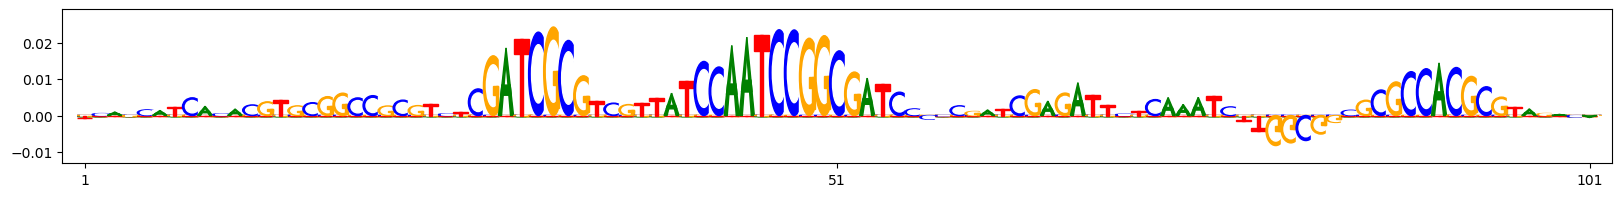

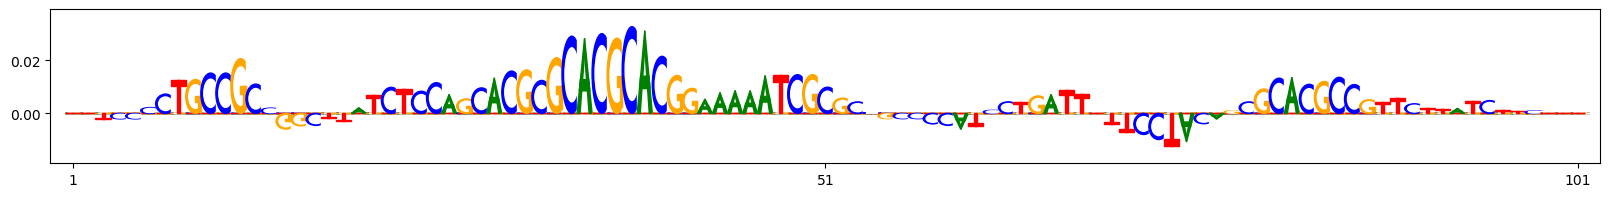

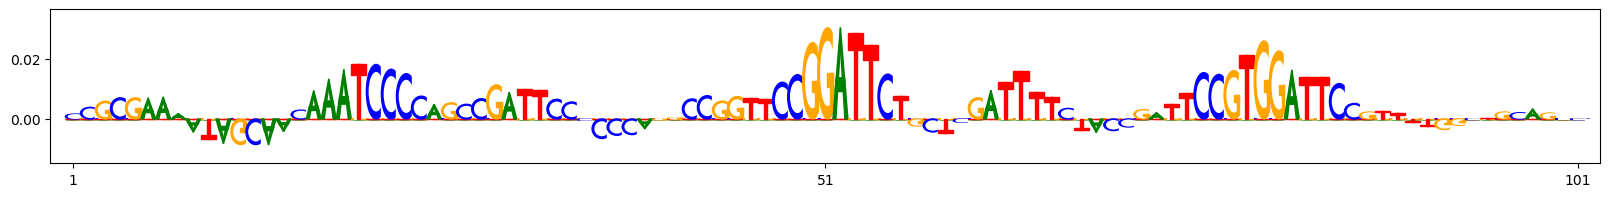

In [121]:
#occlusion, write all the possible ones and predict!
for index, row in df_corpus.iterrows():
    input_sequence = row['dna_string']
    input_score = row['score']
    fasta_seqs = [mutated_sequence(input_sequence, pos) for pos in range(len(input_sequence))]
    df_sequences = pd.DataFrame(fasta_seqs, index= range(len(input_sequence)), columns =['dna_string']) 
    df_sequences["tokens"] = df_sequences["dna_string"].apply(write_ngrams)
    mutagenized_tokens = df_sequences["tokens"].tolist()
    mutagenized_tfidf = extract_idf.transform(mutagenized_tokens) 
    mutagenized_scores = TFIDF_LR.predict_proba(mutagenized_tfidf )[:,1] # y_score
    mutagenized_differences = [input_score - mut_score for mut_score in mutagenized_scores]
    onehot_data = np.array([one_hot_encode_along_channel_axis(x, mutagenized_differences) for x in [input_sequence]])
    dna_plot_weights(onehot_data[0], subticks_frequency=50)